In [1]:
import pyart
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
import xarray as xr
import itertools
import pandas as pd
import datetime as dt
import glob as glob
import zipfile
import cartopy.crs as ccrs

import geopandas
from affine import Affine
from rasterio import features

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pydap/model.py:175: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Mapping
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/pydap/responses/das.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    
    time = time + dt.timedelta(minutes=radar_t_delta)
    
    isfile = len(glob.glob("/g/data/eg3/ab4502/radar/"+rid+"_"+time.strftime("%Y%m%d")+"*")) > 0
    
    if not isfile:
        print("INFO: UNPACKING RADAR FILE FOR ID "+rid+" AND TIME "+time.strftime("%Y%m%d"))
        path_to_zip_file = "/g/data/rq0/level_1/odim_pvol/"+rid+"/"+str(time.year)+"/vol/"+rid+"_"+time.strftime("%Y%m%d")+".pvol.zip"
        directory_to_extract_to = "/g/data/eg3/ab4502/radar/"
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(directory_to_extract_to)
        
    else:
        print("INFO: LOADING RADAR FILE FOR ID "+rid+" AND TIME "+time.strftime("%Y%m%d"))
        
    files = glob.glob("/g/data/eg3/ab4502/radar/"+rid+"_"+time.strftime("%Y%m%d")+"*")
    f_times = [fname.split("/")[-1].split("_")[2].split(".")[0] for fname in files]
    radar_file=pyart.aux_io.read_odim_h5(\
                              files[np.argmin(np.array([abs(time-dt.datetime(time.year,time.month,time.day,int(f[0:2]),int(f[2:4]),int(f[4:6]))) for f in f_times]))],\
                              file_field_names=True)
    return radar_file

INFO: LOADING RADAR FILE FOR ID 2 AND TIME 20200131
INFO: LOADING RADAR FILE FOR ID 27 AND TIME 20200131
INFO: LOADING RADAR FILE FOR ID 50 AND TIME 20200131
INFO: LOADING RADAR FILE FOR ID 66 AND TIME 20200131
INFO: LOADING RADAR FILE FOR ID 71 AND TIME 20200131


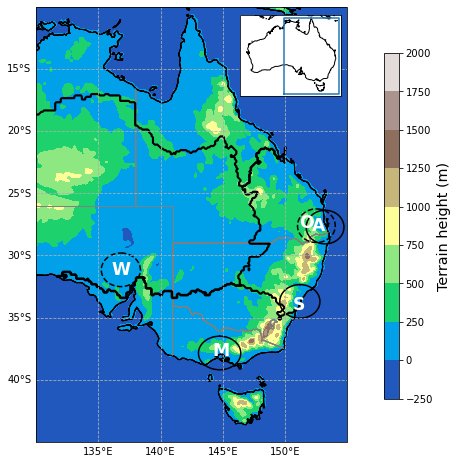

In [3]:
min_lon=130;max_lon=155;min_lat=-45;max_lat=-10
radar02 = load_radar("2", time=dt.datetime(2020,1,31))
radar27 = load_radar("27", time=dt.datetime(2020,1,31))
radar50 = load_radar("50", time=dt.datetime(2020,1,31))
radar66 = load_radar("66", time=dt.datetime(2020,1,31))
radar71 = load_radar("71", time=dt.datetime(2020,1,31))

barra = xr.open_dataset("/g/data/cj37/BARRA/BARRA_R/v1/static/topog-an-slv-PT0H-BARRA_R-v1.nc").\
        sel({"longitude":slice(min_lon-1,max_lon+1),"latitude":slice(min_lat-1,max_lat+1)})
lons,lats = np.meshgrid(barra.longitude.values, barra.latitude.values)

fig=plt.figure(figsize=[10,8])
ax = plt.gca(projection=ccrs.PlateCarree())
topog = ax.contourf(lons,lats,barra["topog"],cmap=plt.get_cmap("terrain"))

def plot_radar(radar,ls="-"):
    disp=pyart.graph.RadarMapDisplay(radar)
    disp.plot_ppi_map("DBZH",1,cmap=pyart.graph.cm_colorblind.HomeyerRainbow, colorbar_label="DBHZ",\
        vmin=-100, vmax=-99,ax=ax, mask_outside=True,colorbar_flag=False,fig=fig,\
        min_lon=min_lon,max_lon=max_lon,min_lat=min_lat,max_lat=max_lat,projection=ccrs.PlateCarree(),resolution="50m")
    disp.plot_range_ring(150,ax=ax,linestyle=ls)
    
plot_radar(radar02)
plot_radar(radar27,ls="--")
plot_radar(radar50,ls="--")
plot_radar(radar66)
plot_radar(radar71)

ax_ins = plt.axes((0.58,0.72,0.14,0.15),projection=ccrs.PlateCarree(),transform=ax.transAxes)
min_lon_ins=110;max_lon_ins=156;min_lat_ins=-46;max_lat_ins=-9
ax_ins.set_xlim([min_lon_ins,max_lon_ins])
ax_ins.set_ylim([min_lat_ins,max_lat_ins])
ax_ins.coastlines()
ax_ins.plot([min_lon,max_lon,max_lon,min_lon,min_lon],[min_lat,min_lat,max_lat,max_lat,min_lat])

ax.set_title("")

fontdict={"fontsize":"xx-large","weight":"bold"}
ax.text(136.8054, -31.1558, "W", va="center", ha="center", color="white",fontdict=fontdict)
ax.text(144.8321, -37.6655, "M", va="center", ha="center", color="white",fontdict=fontdict)
ax.text(151.1731, -33.9465, "S", va="center", ha="center", color="white",fontdict=fontdict)
ax.text(151.7413, -27.4034, "O", va="center", ha="center", color="white",fontdict=fontdict)
ax.text(152.7111, -27.6297, "A", va="center", ha="center", color="white",fontdict=fontdict)

f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
f = geopandas.read_file("/home/548/ab4502/working/NRM_super_clusters/NRM_super_clusters.shp")
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
xr.plot.contour(rasterize(shapes, {"lon":barra.longitude,"lat":barra.latitude}),ax=ax,x="lon",y="lat",
               colors="k")

g = ax.gridlines(draw_labels=True,linestyle="--")
g.bottom_labels = True
g.left_labels = True
g.top_labels = False
g.right_labels = False

cb = plt.colorbar(topog,cax=plt.axes((0.78,0.2,0.02,0.6)))
cb.set_label("Terrain height (m)", fontsize="x-large")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/map.jpeg",quality=100,bbox_inches="tight")